## Installing the required packages

In [1]:
!pip install transformers --quiet
!pip install sentencepiece --quiet
!pip install -Uqq ipdb

You should consider upgrading via the '/Users/furkansimsek/miniconda3/envs/prompt-tuning-for-NLG/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/furkansimsek/miniconda3/envs/prompt-tuning-for-NLG/bin/python -m pip install --upgrade pip' command.


## Importing required libraries

In [16]:
import os
import warnings
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import ipdb

from itertools import chain
from transformers import T5Tokenizer, T5ForConditionalGeneration, get_scheduler
from transformers.optimization import Adafactor, AdamW
from IPython.display import HTML, display

In [ ]:
# Use this when working on Google Colab
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


## Define the Class for Prompt Tuning

In [17]:
class T5PromptTuning(T5ForConditionalGeneration):
    def __init__(self, config):
          super().__init__(config)

    @classmethod
    def from_pretrained(cls, model_name_or_path: str, soft_prompt_path: str = None, number_tokens: int = None,
        initialize_from_vocab: bool = True, random_range: float = 0.5, **kwargs):
      
        model = super().from_pretrained(model_name_or_path, **kwargs)
  
        #  freeze the transformers model
        for param in model.parameters():
            param.requires_grad = False

        # if a saved soft prompt is loaded, use its embeddings
        if soft_prompt_path is not None: 
          model.set_soft_prompt_embeds(soft_prompt_path=soft_prompt_path)
        # else create a new soft prompt
        elif number_tokens is not None:
            print("Initializing soft prompt")
            model.initialize_soft_prompt(number_tokens=number_tokens, initialize_from_vocab=initialize_from_vocab, random_range=random_range)
        return model

    def set_soft_prompt_embeds(self, soft_prompt_path):
        self.soft_prompt = torch.load(
            soft_prompt_path, map_location=torch.device("cpu")
        )
        self.number_tokens = self.soft_prompt.shape[0]
        print(f"Set soft prompt. (number_tokens: {self.number_tokens})")

    def initialize_soft_prompt(self, number_tokens: int = 20, initialize_from_vocab: bool = True, random_range: float = 0.5):
        self.number_tokens = number_tokens
        if initialize_from_vocab:
            init_prompt_value = self.shared.weight[:number_tokens].clone().detach()
        else:
            init_prompt_value = torch.FloatTensor(number_tokens, self.config.d_model).uniform_(-random_range, random_range)

        print(init_prompt_value.shape)
        print(self.shared.weight.shape)

        # Initialize weight
        self.soft_prompt = torch.nn.parameter.Parameter(init_prompt_value)

    def get_soft_params(self):
        return self.soft_prompt

    # this method appends the learned prompt embeddings to the input ids of the input before the forward pass is calculated
    def append_learned_embedding_to_input(self, input_ids):
        inputs_embeds = self.shared(input_ids)
        
        if len(list(inputs_embeds.shape)) == 2: inputs_embeds = inputs_embeds.unsqueeze(0)

        # the shape of the tensor that will be returned will be: [batch_size, max_sequence_length, number_embeddings] -> [8, 600, 512]
        learned_embeds = self.soft_prompt.repeat(inputs_embeds.size(0), 1, 1)
        return torch.cat([learned_embeds, inputs_embeds], dim=1)

    # to make sure that padding token ids of the labels are not taken into account by the loss function
    # this method extends the labels tensor by elements that are ignored by the CrossEntropyLoss function
    # this can be done using the ignore_index value -100
    def extend_labels(self, labels, ignore_index=-100):
        if len(list(labels.shape)) == 1: labels = labels.unsqueeze(0)
        number_of_batches = labels.shape[0]

        # return a new tensor of shape [number_of_batches, number_tokens+labels] that is filled with the ignore_index value (-100)
        return torch.cat([torch.full((number_of_batches, self.number_tokens), ignore_index).to(self.device), labels], dim=1)

    def extend_attention_mask(self, attention_mask):
        # prepend a new dimension (1) to the shape of attention_mask in case it is one dimensional
        if len(list(attention_mask.shape)) == 1: attention_mask = attention_mask.unsqueeze(0)

        # get the number of batches
        number_of_batches = attention_mask.shape[0]

        # return a new tensor of shape [number_of_batches, number_tokens+attention_mask] that is filled with the ones
        return torch.cat([torch.full((number_of_batches, self.number_tokens), 1).to(self.device), attention_mask], dim=1)

    def save_soft_prompt(self, challenge_name, epochs, model_size, number_tokens):
        torch.save(self.soft_prompt, f'soft_prompts/soft_prompt_{challenge_name}_t5_{model_size}_{epochs}_epochs_{number_tokens}_tokens.model')

## Load the Pre-trained model T5 and the tokenizer

In [20]:
import torch as nn
# Check GPU availability
if torch.cuda.is_available():
    dev = torch.device("cuda:0")
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

# Comment out below lines to print Cuda device properties

#print(torch.cuda.get_device_properties(0))
#print(torch.cuda.get_device_name(0))
#torch.cuda.empty_cache()
#torch.cuda.memory_summary(device=None, abbreviated=False)

# Single Soft Prompt-tuning: You can specify the number of prompt tokens that should be used for training and whether the soft prompt
# should be loaded from the vocabulary (default) or should be randomly initialized (set random_range)

# number of prompt tokens
number_prompt_tokens = 50

# If set to true, the soft prompt will be initialized from the models vocabulary
# Otherwise, it will be randomly (uniformly in a range) initialized.
random_range = 0.5
init_from_vocab = True

try:
  del inputs_train_amr
  del inputs_test_amr
  del model_t5_small
  gc.collect()
except Exception:
  pass

# IMPORTANT: set the following variable to either 'small' or 'base' to train on T5 small or base
model_size = 'small'

# Instantiate one T5  model that can be trained on all the 3 datasets

# LOAD a saved soft prompt and a new T5 model (change the path to specify another saved soft prompt)
#model_t5 = T5PromptTuning.from_pretrained('ft5-{model_size}', soft_prompt_path='soft_prompts/soft_prompt_e2e_t5_small_20_epochs_50_tokens.model')

# CREATE a new mode soft prompt and a new T5 model
model_t5 = T5PromptTuning.from_pretrained(f't5-{model_size}', number_tokens=number_prompt_tokens, initialize_from_vocab=init_from_vocab)

# Set the tokenizer
tokenizer_t5 = T5Tokenizer.from_pretrained(f't5-{model_size}')

#moving the models to device(GPU/CPU)
model_t5.to(dev)

Running on the CPU
Initializing soft prompt
torch.Size([50, 512])
torch.Size([32128, 512])


T5PromptTuning(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Dropout(p=0.1, 

## Preprocessing

In [21]:
load_no_duplicate_sets = True

# If you work on google colab upload the challenge datasets to your drive and change the paths below
# to load the datasets from drive

# Load the datasets for the Web NLG 2020 challenge
#train_data_web_nlg = pd.read_csv('drive/MyDrive/MIwDL/data/web_nlg/train/webNLG2020_train.csv' if not load_no_duplicate_sets else 'drive/MyDrive/MIwDL/data/web_nlg/train/webNLG2020_train_no_duplicate_inputs.csv')
#test_data_web_nlg = pd.read_csv('drive/MyDrive/MIwDL/data/web_nlg/test/webNLG2020_test.csv' if not load_no_duplicate_sets else 'drive/MyDrive/MIwDL/data/web_nlg/test/webNLG2020_test_no_duplicate_inputs.csv')

# Load the datasets for the Meaning Representation E2E challenge
#train_data_e2e = pd.read_csv('drive/MyDrive/MIwDL/data/e2e/train/trainset.csv' if not load_no_duplicate_sets else 'drive/MyDrive/MIwDL/data/e2e/train/trainset_no_duplicate_inputs.csv')
#test_data_e2e = pd.read_csv('drive/MyDrive/MIwDL/data/e2e/test/testset_w_refs.csv' if not load_no_duplicate_sets else 'drive/MyDrive/MIwDL/data/e2e/test/testset_no_duplicate_inputs.csv')

# Load the datasets for the Abstract Meaning Representation AMR challenge
#train_data_amr = pd.read_csv('drive/MyDrive/MIwDL/data/amr/abstract_meaning_representation_train.csv' if not load_no_duplicate_sets else 'drive/MyDrive/MIwDL/data/amr/train/amr_train_no_duplicate_inputs.csv')
#test_data_amr = pd.read_csv('drive/MyDrive/MIwDL/data/amr/abstract_meaning_representation_test.csv' if not load_no_duplicate_sets else 'drive/MyDrive/MIwDL/data/amr/test/amr_test_no_duplicate_inputs.csv')

# Load the datasets for the Web NLG 2020 challenge
train_data_web_nlg = pd.read_csv('data/web_nlg/train/webNLG2020_train.csv' if not load_no_duplicate_sets else 'data/web_nlg/train/webNLG2020_train_no_duplicate_inputs.csv')
test_data_web_nlg = pd.read_csv('data/web_nlg/test/webNLG2020_test.csv' if not load_no_duplicate_sets else 'data/web_nlg/test/webNLG2020_test_no_duplicate_inputs.csv')

# Load the datasets for the Meaning Representation E2E challenge
train_data_e2e = pd.read_csv('data/e2e/train/trainset.csv' if not load_no_duplicate_sets else 'data/e2e/train/trainset_no_duplicate_inputs.csv' )
test_data_e2e = pd.read_csv('data/e2e/test/testset_w_refs.csv' if not load_no_duplicate_sets else 'data/e2e/test/testset_no_duplicate_inputs.csv')

# Load the datasets for the Abstract Meaning Representation AMR challenge
train_data_amr = pd.read_csv('data/amr/train/abstract_meaning_representation_train.csv' if not load_no_duplicate_sets else 'data/amr/train/amr_train_no_duplicate_inputs.csv')
test_data_amr = pd.read_csv('data/amr/test/abstract_meaning_representation_test.csv' if not load_no_duplicate_sets else 'data/amr/test/amr_test_no_duplicate_inputs.csv')

In [22]:
# sort the values by ascending order
test_data_web_nlg = test_data_web_nlg.sort_values(by='input_text', ignore_index=True)
train_data_web_nlg = train_data_web_nlg.sort_values(by='input_text', ignore_index=True)

test_data_e2e = test_data_e2e.sort_values(by='input_text', ignore_index=True)
train_data_e2e = train_data_e2e.sort_values(by='input_text', ignore_index=True)

train_data_amr = train_data_amr.sort_values(by='input_text', ignore_index=True)
test_data_amr = test_data_amr.sort_values(by='input_text', ignore_index=True)

# Trimming off the last few datapoints from Web NLG so hat a batch would not leave any remainder.
train_data_web_nlg = train_data_web_nlg.iloc[:35200,:] if not load_no_duplicate_sets else train_data_web_nlg.iloc[:len(train_data_web_nlg)-3,:]
test_data_web_nlg = test_data_web_nlg.iloc[:1720,:] if not load_no_duplicate_sets else test_data_web_nlg.iloc[:len(test_data_web_nlg)-7,:]

# Trimming off the last few datapoints from E2E so that a batch would not leave any remainder.
train_data_e2e = train_data_e2e.iloc[:len(train_data_e2e)-1,:] if not load_no_duplicate_sets else train_data_e2e.iloc[:len(train_data_e2e)-6,:]
test_data_e2e = test_data_e2e.iloc[:len(test_data_e2e)-5,:] if not load_no_duplicate_sets else test_data_e2e.iloc[:len(test_data_e2e)-6,:]

# Trimming off the last few datapoints from AMR so that a batch would not leave any remainder.
train_data_amr = train_data_amr.iloc[:len(train_data_amr)-4,:] if not load_no_duplicate_sets else train_data_amr.iloc[:len(train_data_amr)-6,:]
test_data_amr = test_data_amr.iloc[:len(test_data_amr)-6,:] if not load_no_duplicate_sets else test_data_amr.iloc[:len(test_data_amr)-3,:]

In [23]:
# Set the batch sizes
batch_size_web_nlg = 8
batch_size_e2e = 8
batch_size_amr = 8

number_of_batches_train_web_nlg = int(len(train_data_web_nlg)/batch_size_web_nlg)
number_of_batches_test_web_nlg = int(len(test_data_web_nlg)/batch_size_web_nlg)

number_of_batches_train_e2e = int(len(train_data_e2e)/batch_size_e2e)
number_of_batches_test_e2e = int(len(test_data_e2e)/batch_size_e2e)

number_of_batches_train_amr = int(len(train_data_amr)/batch_size_amr)
number_of_batches_test_amr = int(len(test_data_amr)/batch_size_amr)

print('--- Number of train batches Web NLG: ' + str(number_of_batches_train_web_nlg) + ' --- ')
print('--- Number of test  batches Web NLG: ' + str(number_of_batches_test_web_nlg) + '  --- \n')

print('--- Number of train batches E2E : ' + str(number_of_batches_train_e2e) + ' --- ')
print('--- Number of test  batches E2E : ' + str(number_of_batches_test_e2e) + '  --- \n')

print('--- Number of train batches AMR : ' + str(number_of_batches_train_amr) + ' --- ')
print('--- Number of test  batches AMR : ' + str(number_of_batches_test_amr) + '  --- ')

--- Number of train batches Web NLG: 1640 --- 
--- Number of test  batches Web NLG: 74  --- 

--- Number of train batches E2E : 607 --- 
--- Number of test  batches E2E : 78  --- 

--- Number of train batches AMR : 168 --- 
--- Number of test  batches AMR : 18  --- 


In [24]:
def create_list_of_batches(batch_size, num_batches, data, tokenizer):
# Create List of batches for inputs and labels
    inputs = []
    labels = []
    for i in range(num_batches):
        input_batch=[]
        label_batch=[]
        for index,row in data[i*batch_size:i*batch_size+batch_size].iterrows():
#          input_batch.append('translate from Graph to Text: '+row['input_text']+'</s>')
#          label_batch.append(row['target_text']+'</s>')

          input_batch.append('translate from Graph to Text: '+row['input_text'])
          label_batch.append(row['target_text'])

        input_batch=tokenizer.batch_encode_plus(input_batch,padding=True, return_tensors='pt', return_attention_mask=True)
        label_batch=tokenizer.batch_encode_plus(label_batch,padding=True, return_tensors='pt', return_attention_mask=True)

        input_batch=input_batch.to(dev)
        label_batch=label_batch.to(dev)

        inputs.append(input_batch)
        labels.append(label_batch)
    return inputs, labels

inputs_train_web_nlg, \
labels_train_web_nlg = create_list_of_batches(batch_size=batch_size_web_nlg,
                                              num_batches=number_of_batches_train_web_nlg,
                                              data=train_data_web_nlg,
                                              tokenizer=tokenizer_t5)
inputs_test_web_nlg, \
labels_test_web_nlg = create_list_of_batches(batch_size=batch_size_web_nlg,
                                              num_batches=number_of_batches_test_web_nlg,
                                              data=test_data_web_nlg,
                                              tokenizer=tokenizer_t5)
inputs_train_e2e, \
labels_train_e2e = create_list_of_batches(batch_size=batch_size_e2e,
                                              num_batches=number_of_batches_train_e2e,
                                              data=train_data_e2e,
                                              tokenizer=tokenizer_t5)
inputs_test_e2e, \
labels_test_e2e = create_list_of_batches(batch_size=batch_size_e2e,
                                              num_batches=number_of_batches_test_e2e,
                                              data=test_data_e2e,
                                              tokenizer=tokenizer_t5)
inputs_train_amr, \
labels_train_amr = create_list_of_batches(batch_size=batch_size_amr,
                                              num_batches=number_of_batches_train_amr,
                                              data=train_data_amr,
                                              tokenizer=tokenizer_t5)
inputs_test_amr, \
labels_test_amr = create_list_of_batches(batch_size=batch_size_amr,
                                              num_batches=number_of_batches_test_amr,
                                              data=test_data_amr,
                                              tokenizer=tokenizer_t5)


## Set the Optimizer for T5

In [25]:
def optimizer_adafactor(model, 
              lr=0.3,
              eps=(1e-30, 1e-3),
              clip_threshold=1.0,
              decay_rate=-0.8,
              beta1=None,
              weight_decay=1e-5,
              relative_step=False,   
              scale_parameter=False,
              warmup_init=False):
  
    return Adafactor(
        [model.get_soft_params()],
        lr=lr,
        eps=eps,
        clip_threshold=clip_threshold,
        decay_rate=decay_rate,
        beta1=beta1,
        weight_decay=weight_decay,
        relative_step=relative_step,
        scale_parameter=scale_parameter,
        warmup_init=warmup_init
    )
optimizer_t5 = optimizer_adafactor(model_t5)

## Training Routine Definition

In [26]:
def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss,value=value, max=max))

def trainer(model, num_batches, inputs, labels, optimizer, challenge_name, model_name):
    # Set the model in training mode
    model.train()
    
    loss_per_10_steps=[]
    for epoch in range(1,epochs+1):
      print('Running epoch: {}'.format(epoch))
      running_loss=0

      out = display(progress(1, num_batches+1), display_id=True)
      for i in range(num_batches):

        # clear out the gradients of all Variables
        optimizer.zero_grad()

        # Forward propogation
        #outputs = model(input_ids=inputs[i]['input_ids'], labels=labels[i]['input_ids'], attention_mask=inputs[i]['attention_mask'])
        outputs = model(inputs_embeds=model.append_learned_embedding_to_input(inputs[i]['input_ids']), labels=model.extend_labels(labels[i]['input_ids']), attention_mask= model.extend_attention_mask(inputs[i]['attention_mask']))
        
        loss = outputs.loss
        loss_num=loss.item()
        logits = outputs.logits
        running_loss+=loss_num
        if i%10 == 0: loss_per_10_steps.append(loss_num)
        out.update(progress(loss_num,i, num_batches+1))

        # calculating the gradients
        loss.backward()

        #updating the params
        optimizer.step()

      running_loss=running_loss/int(num_batches)
      print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))

      # plot the loss
      steps = [i for i in range(len(loss_per_10_steps))]
      plt.plot(steps, loss_per_10_steps)
      plt.title(f'Loss curve for the {challenge_name} challenge trained for {epochs} epochs on T5-{model_name}')
      plt.xlabel('Steps')
      plt.ylabel('Loss')
      plt.show()
    return model

## Training Process

In [28]:
# Set the number of epochs to train
epochs = 1

Running epoch: 1


Epoch: 1 , Running loss: 3.3124619779132662


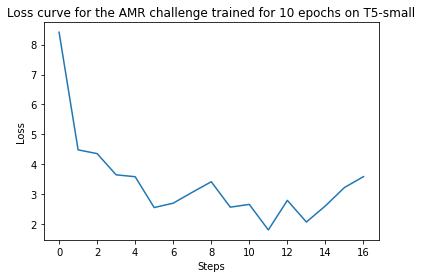

Running epoch: 2


Epoch: 2 , Running loss: 2.4383475376026973


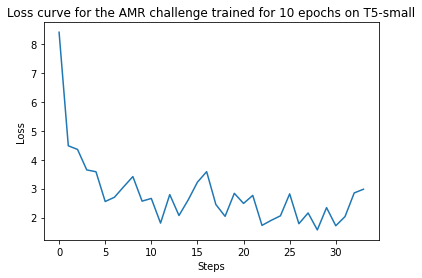

Running epoch: 3


Epoch: 3 , Running loss: 2.2138393031699315


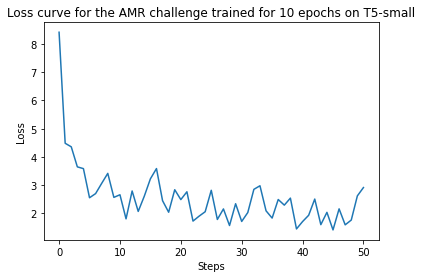

Running epoch: 4


Epoch: 4 , Running loss: 2.053981678826468


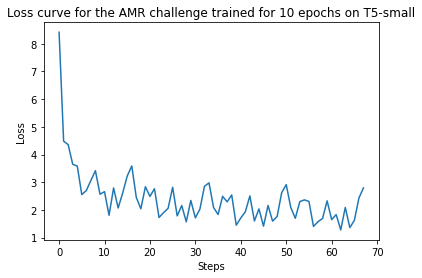

Running epoch: 5


Epoch: 5 , Running loss: 1.9818195601304371


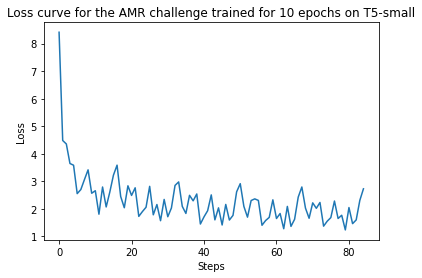

Running epoch: 6


Epoch: 6 , Running loss: 1.907228701881


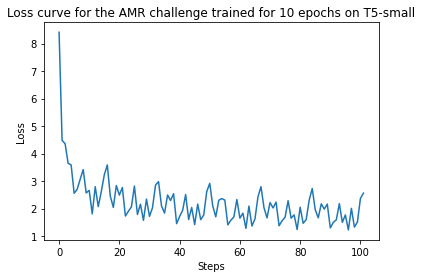

Running epoch: 7


Epoch: 7 , Running loss: 1.8696586418719519


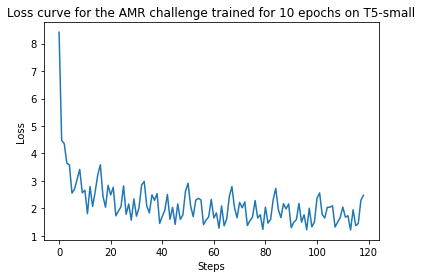

Running epoch: 8


Epoch: 8 , Running loss: 1.8349916296345847


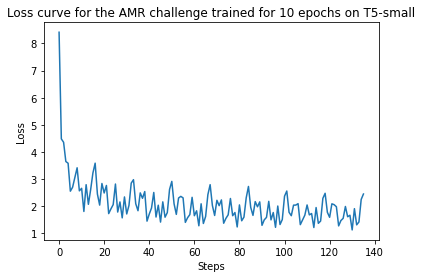

Running epoch: 9


Epoch: 9 , Running loss: 1.7894676384471713


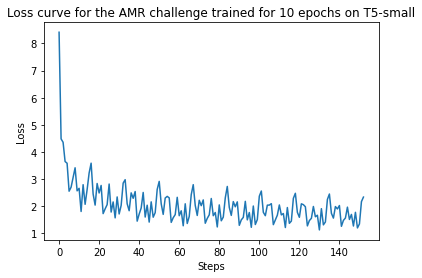

Running epoch: 10


Epoch: 10 , Running loss: 1.7495287316186088


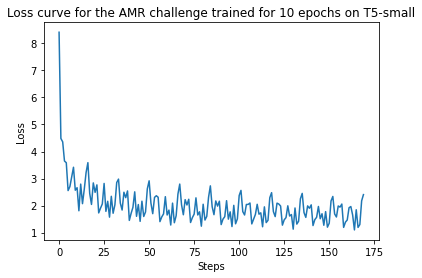

In [ ]:
# Since this is Single soft prompt tuning, chose one of the following three cells only

In [29]:
# Train T5 on AMR
model_t5 = trainer(model=model_t5, num_batches=number_of_batches_train_amr, inputs=inputs_train_amr, labels=labels_train_amr,optimizer=optimizer_t5,challenge_name='AMR', model_name=f'{model_size}')

Running epoch: 1


KeyboardInterrupt: 

In [ ]:
# Train T5 on E2E
model_t5 = trainer(model=model_t5, num_batches=number_of_batches_train_e2e, inputs=inputs_train_e2e, labels=labels_train_e2e,optimizer=optimizer_t5,challenge_name='E2E', model_name=f'{model_size}')

In [ ]:
# Train T5 on Web NLG
model_t5 = trainer(model=model_t5, num_batches=number_of_batches_train_web_nlg, inputs=inputs_train_web_nlg, labels=labels_train_web_nlg,optimizer=optimizer_t5,challenge_name='Web NLG', model_name=f'{model_size}')

## Evaluate a Model

In [30]:
# use this method to generate text for each test input ids, then save the predictions
# in a file 'hypothesis' for web nlg and amr to later use the official evaluation script for the 
# challenges
def make_predictions(model, inputs_test, tokenizer, challenge_name):

  model_predictions = []
  model.eval()
  with torch.no_grad():
    for i in range(len(inputs_test)):
      embeds = model.append_learned_embedding_to_input(inputs_test[i]['input_ids'])
      output = tokenizer.batch_decode(model.generate(inputs_embeds=embeds,
                                                     #do_sample=True, 
                                                     max_length=400,
                                                     #top_p=0.92,
                                                     #top_k=0,
                                                     bos_token_id=0,
                                                     pad_token_id=0,
                                                     eos_token_id=1,
                                                     use_cache=True,
                                                     attention_mask=model.extend_attention_mask(inputs_test[i]['attention_mask'])
                                                     ),
                                      skip_special_tokens=True,
                                      )
      print(output)
      model_predictions.append([x.replace('<pad>','').replace('</s>','').strip() for x in output])

    # flatten the predictions list which has the length of batch_size * number_of_batches
    model_predictions = list(chain(*model_predictions))  
  model.train()

  # if you are working on colab set the path to which you want to save the output file
  #with open('drive/MyDrive/MIwDL/data/' + challenge_name + '/test/prompt_tuning_hypothesis/hypothesis', 'w') as file:
  #  for i in range(len(model_predictions)):
  #    file.write(model_predictions[i] + '\n' if i < len(model_predictions)-1 else model_predictions[i])

  with open(f'data/{challenge_name}/test/prompt_tuning_hypothesis/hypothesis', 'w') as file:
    for i in range(len(model_predictions)):
      file.write(model_predictions[i] + '\n' if i < len(model_predictions)-1 else model_predictions[i])

  return model_predictions

In [ ]:
model_predictions = make_predictions(model=model_t5,inputs_test=inputs_test_e2e,tokenizer=tokenizer_t5,challenge_name='e2e')

['Blue Spice is a coffee shop in the city centre.', 'Blue Spice is a coffee shop located in the riverside area.', 'Blue Spice is a coffee shop near Crowne Plaza Hotel.', 'Blue Spice is a coffee shop near Burger King.', 'Blue Spice is a coffee shop near Crowne Plaza Hotel.', 'Blue Spice is located in the city centre.', 'Blue Spice is a pub located in the riverside.', 'Blue Spice is a pub near Crowne Plaza Hotel.']
['Blue Spice is a pub near Burger King.', 'Blue Spice is a pub near Crowne Plaza Hotel.', 'Blue Spice is located in the city centre.', 'Blue Spice is located in the city centre.', 'Blue Spice is a Chinese pub in the riverside area near Rainbow Vegetarian Café.', 'Blue Spice is a family-friendly pub.', 'Blue Spice is a pub in the city centre.', 'Blue Spice is located in the city centre.']
['Blue Spice is a pub that is not family friendly.', 'Blue Spice is a family friendly pub.', 'Blue Spice is located in the city centre.', 'Blue Spice is located in the city centre.', 'Blue Spi

In [ ]:
model_predictions = make_predictions(model=model_t5,inputs_test=inputs_test_amr,tokenizer=tokenizer_t5,challenge_name='amr')

In [ ]:
model_predictions = make_predictions(model=model_t5,inputs_test=inputs_test_web_nlg,tokenizer=tokenizer_t5,challenge_name='web_nlg')

## Save the Soft Prompt

In [ ]:
model_t5.save_soft_prompt(challenge_name='e2e', epochs=str(epochs), model_size=f'{model_size}', number_tokens=number_prompt_tokens)

In [ ]:
model_t5.save_soft_prompt(challenge_name='web_nlg', epochs=str(epochs), model_size=f'{model_size}', number_tokens=number_prompt_tokens)

In [ ]:
model_t5.save_soft_prompt(challenge_name='amr', epochs=str(epochs), model_size=f'{model_size}', number_tokens=number_prompt_tokens)